<a href="https://colab.research.google.com/github/yan201839968/lectures/blob/master/ST456_Assignment_2_31849.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ST456 Assignment 2
## Candidate number: 31849

# Notebook Set Up

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('drive/My Drive/POSTGRADUATE/Lent Term/ST456 Deep Learning/Assignment 2')

In [ ]:
# The following libraries are needed to run this notebook. 
#!pip install pandas
#!pip install requests
#!pip install folium
#!pip install imgaug

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding, LSTM
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
# To ensure reproducibility
seed_value=0
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

#P1

##Set Up

In [ ]:
from keras.datasets import cifar10
(data_train, label_train), (data_test, label_test) = cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [ ]:
assert data_train.shape == (50000, 32, 32, 3)
assert data_test.shape == (10000, 32, 32, 3)
assert label_train.shape == (50000, 1)
assert label_test.shape == (10000, 1)

In [ ]:
# normalize inputs
data_train = data_train.astype('float32')
data_test = data_test.astype('float32')
data_train = data_train / 255.0
data_test = data_test / 255.0

In [ ]:
# one hot encode outputs
label_train = np_utils.to_categorical(label_train)
label_test = np_utils.to_categorical(label_test)
num_classes = label_test.shape[1]

##P1.1

In [ ]:
# 3-block VGG architecture
model1 = Sequential(name='model_1')
model1.add(Conv2D(32, (5, 5), input_shape=(32, 32, 3), activation='relu', padding='same', name='convo_1'))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=2, name='pooling_1'))
model1.add(Conv2D(32, (5, 5), activation='relu', padding='same', name='convo_2'))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=2, name='pooling_2'))
model1.add(Conv2D(32, (5, 5), activation='relu', padding='same', name='convo_3'))
model1.add(MaxPooling2D(pool_size=(2, 2), strides=2, name='pooling_3'))
model1.add(Flatten(name='flatten'))
model1.add(Dense(1000, activation='relu', name='hidden_layer'))
model1.add(Dense(num_classes, activation='softmax', name='final_output'))

print(model1.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convo_1 (Conv2D)            (None, 32, 32, 32)        2432      
                                                                 
 pooling_1 (MaxPooling2D)    (None, 16, 16, 32)        0         
                                                                 
 convo_2 (Conv2D)            (None, 16, 16, 32)        25632     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 8, 8, 32)          0         
                                                                 
 convo_3 (Conv2D)            (None, 8, 8, 32)          25632     
                                                                 
 pooling_3 (MaxPooling2D)    (None, 4, 4, 32)          0         
                                                                 
 flatten (Flatten)           (None, 512)               0   

##P1.2

In [ ]:
# Compile model
from keras.metrics import TopKCategoricalAccuracy
sgd = SGD(learning_rate=0.01, momentum=0.9, decay=0.01/100, nesterov=False)
model1.compile(loss='categorical_crossentropy', optimizer=sgd,
               metrics=['accuracy',
                        TopKCategoricalAccuracy(k=3, name='top3acc', dtype=None),
                        TopKCategoricalAccuracy(k=5, name='top5acc', dtype=None)])

# Fit model
history1 = model1.fit(data_train, label_train, validation_split=0.25,
                      epochs=100, batch_size=128, steps_per_epoch=50, shuffle=True, verbose=0)

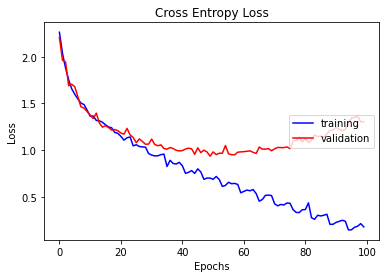

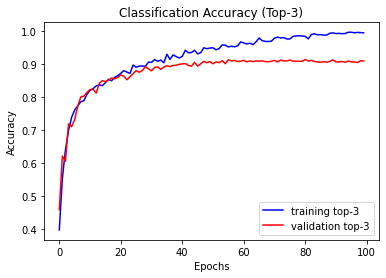

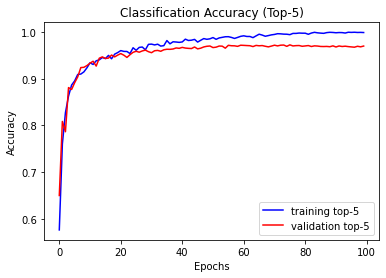

In [ ]:
# Training and validation loss against epochs
plt.title('Cross Entropy Loss')
plt.plot(history1.history['loss'], color='blue', label='training')
plt.plot(history1.history['val_loss'], color='red', label='validation')
plt.legend(loc="center right")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Training and validation accuracy against epochs
plt.title('Classification Accuracy (Top-3)')
plt.plot(history1.history['top3acc'], color='blue', label='training top-3')
plt.plot(history1.history['val_top3acc'], color='red', label='validation top-3')
plt.legend(loc="lower right")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.title('Classification Accuracy (Top-5)')
plt.plot(history1.history['top5acc'], color='blue', label='training top-5')
plt.plot(history1.history['val_top5acc'], color='red', label='validation top-5')
plt.legend(loc="lower right")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
score1 = model1.evaluate(data_test, label_test, verbose=0)
print("Accuracy: %.2f%%" % (score1[1]*100))

Accuracy: 69.74%


The training loss decreases steadily over 100 epochs. The validation loss, on the other hand, decreases slower than training loss and then starts to increase at around epoch 60. This could be due to the model overfitting to the training data.

Both top-3 and top-5 accuracy increase exponentially in the initial epochs. The top-5 training accuracy start to slow down at epoch 40 while the top-3 accuracy conitinues to increase slightly. Both validation accuracies increase exponentially then start to plateau at epoch 20. The top-3 accuracy reaches a lower value of close to 0.9, however, as compared to the top-5 accuracy which reaches 0.95. This is expected as the top-5 accuracy has a more lenient criteria than top-3 - it looks at whether or not the model's top 5 probabilities match the true label while top-3 accuracy only considers the top 3 probabilities. The overall model acuracy tested on the test dataset is 69.74%, which is not particularly high.

##P1.3

This model includes a dropout layer after the dense hidden layer and before the final output layer. The dropout layer deals with the overfitting mentioned in P1.2, by randomly excluding 20% of the inputs in each iteration during training. This prevents the model from overfitting to the dataset as some inputs are not present each time, thus it generates some randomness and avoids over reliance on the few inputs, instead forcing the model to train over all of them.

In [ ]:
# 3-block VGG architecture with dropout layer
model2 = Sequential(name='model_2')
model2.add(Conv2D(32, (5, 5), input_shape=(32, 32, 3), activation='relu', padding='same', name='convo_1'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=2, name='pooling_1'))
model2.add(Conv2D(32, (5, 5), activation='relu', padding='same', name='convo_2'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=2, name='pooling_2'))
model2.add(Conv2D(32, (5, 5), activation='relu', padding='same', name='convo_3'))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=2, name='pooling_3'))
model2.add(Flatten(name='flatten'))
model2.add(Dense(1000, activation='relu', name='hidden_layer'))
model2.add(Dropout(0.2, name='dropout')) # exclude 20% of inputs each time
model2.add(Dense(num_classes, activation='softmax', name='final_output'))

print(model2.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convo_1 (Conv2D)            (None, 32, 32, 32)        2432      
                                                                 
 pooling_1 (MaxPooling2D)    (None, 16, 16, 32)        0         
                                                                 
 convo_2 (Conv2D)            (None, 16, 16, 32)        25632     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 8, 8, 32)          0         
                                                                 
 convo_3 (Conv2D)            (None, 8, 8, 32)          25632     
                                                                 
 pooling_3 (MaxPooling2D)    (None, 4, 4, 32)          0         
                                                                 
 flatten (Flatten)           (None, 512)               0   

In [ ]:
# Compile model
model2.compile(loss='categorical_crossentropy', optimizer=sgd,
               metrics=['accuracy',
                        TopKCategoricalAccuracy(k=3, name='top3acc', dtype=None),
                        TopKCategoricalAccuracy(k=5, name='top5acc', dtype=None)])

# Fit model
history2 = model2.fit(data_train, label_train, validation_split=0.25,
                      epochs=100, batch_size=128, steps_per_epoch=50, shuffle=True, verbose=0)

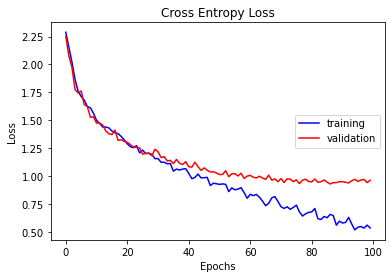

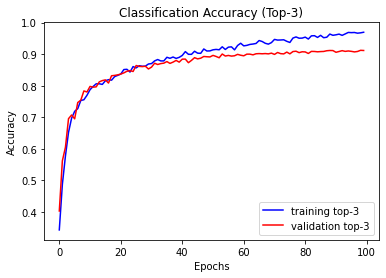

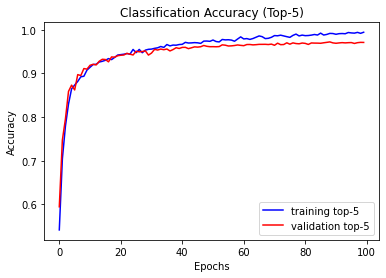

In [ ]:
# Training and validation loss against epochs
plt.title('Cross Entropy Loss')
plt.plot(history2.history['loss'], color='blue', label='training')
plt.plot(history2.history['val_loss'], color='red', label='validation')
plt.legend(loc="center right")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Training and validation accuracy against epochs
plt.title('Classification Accuracy (Top-3)')
plt.plot(history2.history['top3acc'], color='blue', label='training top-3')
plt.plot(history2.history['val_top3acc'], color='red', label='validation top-3')
plt.legend(loc="lower right")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.title('Classification Accuracy (Top-5)')
plt.plot(history2.history['top5acc'], color='blue', label='training top-5')
plt.plot(history2.history['val_top5acc'], color='red', label='validation top-5')
plt.legend(loc="lower right")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
score2 = model2.evaluate(data_test, label_test, verbose=0)
print("Accuracy: %.2f%%" % (score2[1]*100))

Accuracy: 68.07%


The improvement can be seen in the first graph, where validation loss no longer decreased then increased, but decreased steadily over all 100 epochs. Validation loss in both P1.2 and P1.3 reached the minimum at around 1 but this model with a dropout layer ensured that the loss remains stable at 1.

Top-3 and top-5 accuracy values remain roughly the same, with the only difference being top-5 accuracy reaching an even higher stable value of roughly 0.97. The model accuracy tested on the test dataset has slightly worsened by 1.67% to 68.07%. It is unclear why but one could guess that due to the dropout layer, the model now trains over a smaller dataset in the last step and hence becomes more inaccurate despite fixing the problem of overfitting. There seems to be a trade-off between the two. Regardless, the improvement of the top-5 accuracy shows that while the top probability may not always be the most accurate compared to the model in P1.2, the model still continues to generate good or even better top 5 probabilities. It is now slightly less precise and accurate but outputs better predictions in general. 

##P1.4

### Improved Model 1

The first improvement I have made to the model is to augment the data. I have used the same model architecture as in P1.1 for simplicity sake and to isolate the effect of data augmentation. This gives an idea as to how much of the areas of improvement can be attributed to the quality of the dataset as opposed to purely model architecture.

Data augmentation was done by shifting the image by 1 unit height and width wise and then also flipping the images. The new dataset is then saved and fed into the model as training dataset. This artificially expands the dataset and gives the model more to train on, creating a more robust model that prevents overfitting. This improves performance, as seen below.

In [ ]:
# Data augmentation
model3 = Sequential(name='model_3')
model3.add(Conv2D(32, (5, 5), input_shape=(32, 32, 3), activation='relu', padding='same', name='convo_1'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=2, name='pooling_1'))
model3.add(Conv2D(32, (5, 5), activation='relu', padding='same', name='convo_2'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=2, name='pooling_2'))
model3.add(Conv2D(32, (5, 5), activation='relu', padding='same', name='convo_3'))
model3.add(MaxPooling2D(pool_size=(2, 2), strides=2, name='pooling_3'))
model3.add(Flatten(name='flatten'))
model3.add(Dense(1000, activation='relu', name='hidden_layer'))
model3.add(Dense(num_classes, activation='softmax', name='final_output'))

print(model3.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convo_1 (Conv2D)            (None, 32, 32, 32)        2432      
                                                                 
 pooling_1 (MaxPooling2D)    (None, 16, 16, 32)        0         
                                                                 
 convo_2 (Conv2D)            (None, 16, 16, 32)        25632     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 8, 8, 32)          0         
                                                                 
 convo_3 (Conv2D)            (None, 8, 8, 32)          25632     
                                                                 
 pooling_3 (MaxPooling2D)    (None, 4, 4, 32)          0         
                                                                 
 flatten (Flatten)           (None, 512)               0   

In [ ]:
# Data generator
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
it_train = datagen.flow(data_train, label_train, batch_size=128)

# Compile model
from keras.metrics import TopKCategoricalAccuracy
sgd = SGD(learning_rate=0.01, momentum=0.9, decay=0.01/100, nesterov=False)
model3.compile(loss='categorical_crossentropy', optimizer=sgd,
               metrics=['accuracy',
                        TopKCategoricalAccuracy(k=3, name='top3acc', dtype=None),
                        TopKCategoricalAccuracy(k=5, name='top5acc', dtype=None)])

# Fit model
steps = int(data_train.shape[0] / 128)
history3 = model3.fit(it_train, validation_data=(data_test, label_test),
                      epochs=100, steps_per_epoch=steps, shuffle=True, verbose=0)

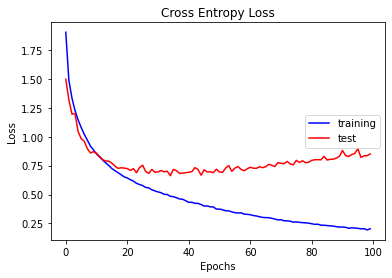

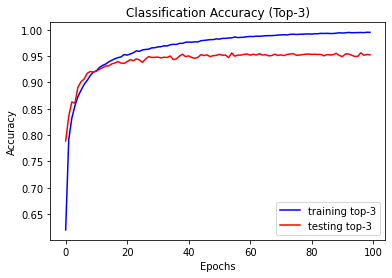

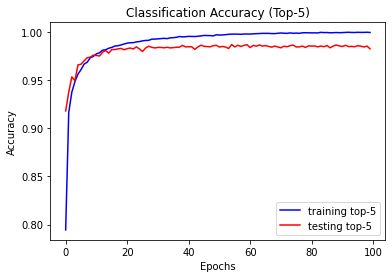

In [ ]:
# Training and test loss against epochs
plt.title('Cross Entropy Loss')
plt.plot(history3.history['loss'], color='blue', label='training')
plt.plot(history3.history['val_loss'], color='red', label='test')
plt.legend(loc="center right")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Training and test accuracy against epochs
plt.title('Classification Accuracy (Top-3)')
plt.plot(history3.history['top3acc'], color='blue', label='training top-3')
plt.plot(history3.history['val_top3acc'], color='red', label='testing top-3')
plt.legend(loc="lower right")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.title('Classification Accuracy (Top-5)')
plt.plot(history3.history['top5acc'], color='blue', label='training top-5')
plt.plot(history3.history['val_top5acc'], color='red', label='testing top-5')
plt.legend(loc="lower right")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
score3 = model3.evaluate(data_test, label_test, verbose=0)
print("Accuracy: %.2f%%" % (score3[1]*100))

Accuracy: 79.15%


There is a huge improvement in model accuracy (computed on test dataset) from 69.74% to an impressive 79.15%. Test loss slightly increases towards the end, but not as much as before - data augmentation has indeed helped with overfitting but could be further improved with an additional dropout layer as specified before. Top-3 and top-5 test accuracy values have also improved tremendously, to 0.95 and 0.98 respectively, up from 0.9 and 0.95 before.

It seems like the quality of dataset could be very much hindering the performance of our model. Regardless of how we would like to extend our model architecture, this will be good to bear in mind that the performance of the model could still be limited to something more simple and fundamental like the quality of the dataset.

### Improved Model 2

The second improvement made is to

1) add a fourth VGG block,

2) stack the convolutional layers, and

3) increase the filters deeper into the model, from 32 to 64 to 128 and then 256 for each VGG block.

This creates a deeper and wider neural network that allows for the model to truly learn the features of the data. Increasing the number of convolutional layers as well as the number of filters gives the model the opportunity to generate more feature maps through more filters and thus it is able to extract more image features that will help recognise patterns in unseen data. The drastic expansion in model width and depth is countered by max pooling layers that reduce the dimensionality of each feature map but still retains important information.

In [ ]:
# Stacking convolutional layers and increasing number of feature maps
model4 = Sequential(name='model_4')
model4.add(Conv2D(32, (5, 5), input_shape=(32, 32, 3), activation='relu', padding='same', name='convo_1.1'))
model4.add(Conv2D(32, (5, 5), activation='relu', padding='same', name='convo_1.2'))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=2, name='pooling_1'))
model4.add(Conv2D(64, (5, 5), activation='relu', padding='same', name='convo_2.1'))
model4.add(Conv2D(64, (5, 5), activation='relu', padding='same', name='convo_2.2'))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=2, name='pooling_2'))
model4.add(Conv2D(128, (5, 5), activation='relu', padding='same', name='convo_3.1'))
model4.add(Conv2D(128, (5, 5), activation='relu', padding='same', name='convo_3.2'))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=2, name='pooling_3'))
model4.add(Conv2D(256, (5, 5), activation='relu', padding='same', name='convo_4.1'))
model4.add(Conv2D(256, (5, 5), activation='relu', padding='same', name='convo_4.2'))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=2, name='pooling_4'))
model4.add(Flatten(name='flatten'))
model4.add(Dense(1000, activation='relu', name='hidden_layer'))
model4.add(Dense(num_classes, activation='softmax', name='final_output'))

print(model4.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convo_1.1 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 convo_1.2 (Conv2D)          (None, 32, 32, 32)        25632     
                                                                 
 pooling_1 (MaxPooling2D)    (None, 16, 16, 32)        0         
                                                                 
 convo_2.1 (Conv2D)          (None, 16, 16, 64)        51264     
                                                                 
 convo_2.2 (Conv2D)          (None, 16, 16, 64)        102464    
                                                                 
 pooling_2 (MaxPooling2D)    (None, 8, 8, 64)          0         
                                                                 
 convo_3.1 (Conv2D)          (None, 8, 8, 128)         2049

In [ ]:
# Compile model
from keras.metrics import TopKCategoricalAccuracy
sgd = SGD(learning_rate=0.01, momentum=0.9, decay=0.01/100, nesterov=False)
model4.compile(loss='categorical_crossentropy', optimizer=sgd,
               metrics=['accuracy',
                        TopKCategoricalAccuracy(k=3, name='top3acc', dtype=None),
                        TopKCategoricalAccuracy(k=5, name='top5acc', dtype=None)])

# Fit model
history4 = model4.fit(data_train, label_train, validation_data=(data_test, label_test),
                      epochs=200, batch_size=128, steps_per_epoch=50, shuffle=True, verbose=0) # increased number of epochs

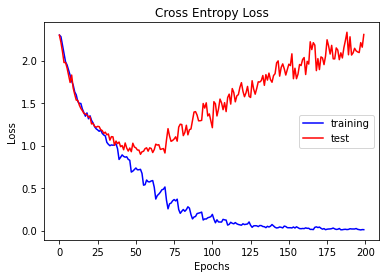

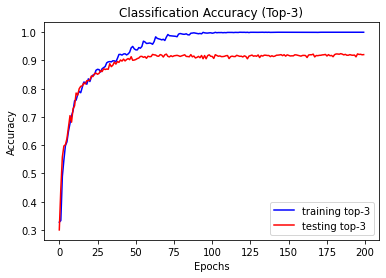

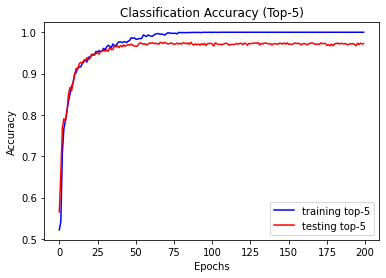

In [ ]:
# Training and test loss against epochs
plt.title('Cross Entropy Loss')
plt.plot(history4.history['loss'], color='blue', label='training')
plt.plot(history4.history['val_loss'], color='red', label='test')
plt.legend(loc="center right")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Training and test accuracy against epochs
plt.title('Classification Accuracy (Top-3)')
plt.plot(history4.history['top3acc'], color='blue', label='training top-3')
plt.plot(history4.history['val_top3acc'], color='red', label='testing top-3')
plt.legend(loc="lower right")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.title('Classification Accuracy (Top-5)')
plt.plot(history4.history['top5acc'], color='blue', label='training top-5')
plt.plot(history4.history['val_top5acc'], color='red', label='testing top-5')
plt.legend(loc="lower right")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
score4 = model4.evaluate(data_test, label_test, verbose=0)
print("Accuracy: %.2f%%" % (score4[1]*100))

Accuracy: 71.86%


The model accuracy increases slightly from 69.74% to 71.86%. There is a lot of overfitting in this model as seen from the huge increase in test loss from epoch 50. This is due to the increasd width and depth in the model. There probably is no need to include so many filters and layers, thus the model is overfitting to the data, finding features that are not actually important but only relevant to the specific training data used.

The top-3 and top-5 test accuracy values remain the same at 0.9 and 0.95 respectively. All in all, there is only a slight improvement in model performance but not drastic. I would expect that the increase in complexity of the model by increasing filters and layers does improve the model, but too much of it causes overfitting which offsets a lot of the potential improvement.

### Improved Model 3

This is why the third improvement made to the model is the following: I kept the increased width in the second model and increased the number of filters in each cnvolutional layer. To combat potential overfitting which has proven throughout the question to be a problem, dropout layers are added. As shown in P1.3, adding a dropout layer improved the model dramatically. This time, instead of adding one between the fully connected layers, a dropout layer is added after each VGG block. With such a dropout regularisation, a wider or deeper model can be used as the overfitting that happens with more layers or nodes is offset by randomly excluding some amount of data in each iteration during the training process. This is why the dropout rate is increased with each one layer, from 20% to 30% and finally 50%, as the number of filters increase with each layer as well.

Along with that, the batch size and number of epochs are also increased to 256 and 500 respectively to allow for more training opportunities to learn the features of the data better. However, given that the model built is more complex, they are not increased by too much to prevent overfitting as well.

In [ ]:
# Dropout regularisation trained with increased epochs and batch size
from tensorflow.keras.layers import BatchNormalization
model5 = Sequential(name='model_5')
model5.add(Conv2D(32, (5, 5), input_shape=(32, 32, 3), activation='relu', padding='same', name='convo_1'))
model5.add(MaxPooling2D(pool_size=(2, 2), strides=2, name='pooling_1'))
model5.add(Dropout(0.2, name='dropout_1'))
model5.add(Conv2D(64, (5, 5), activation='relu', padding='same', name='convo_2'))
model5.add(MaxPooling2D(pool_size=(2, 2), strides=2, name='pooling_2'))
model5.add(Dropout(0.3, name='dropout_2'))
model5.add(Conv2D(128, (5, 5), activation='relu', padding='same', name='convo_3'))
model5.add(MaxPooling2D(pool_size=(2, 2), strides=2, name='pooling_3'))
model5.add(Dropout(0.5, name='dropout_3'))
model5.add(Flatten(name='flatten'))
model5.add(Dense(1000, activation='relu', name='hidden_layer'))
model5.add(Dense(num_classes, activation='softmax', name='final_output'))

print(model5.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convo_1 (Conv2D)            (None, 32, 32, 32)        2432      
                                                                 
 pooling_1 (MaxPooling2D)    (None, 16, 16, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 convo_2 (Conv2D)            (None, 16, 16, 64)        51264     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 8, 8, 64)          0         
                                                                 
 dropout_2 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 convo_3 (Conv2D)            (None, 8, 8, 128)         2049

In [ ]:
# Compile model
from keras.metrics import TopKCategoricalAccuracy
sgd = SGD(learning_rate=0.01, momentum=0.9, decay=0.01/100, nesterov=False)
model5.compile(loss='categorical_crossentropy', optimizer=sgd,
               metrics=['accuracy',
                        TopKCategoricalAccuracy(k=3, name='top3acc', dtype=None),
                        TopKCategoricalAccuracy(k=5, name='top5acc', dtype=None)])

# Fit model
history5 = model5.fit(data_train, label_train, validation_data=(data_test, label_test),
                      epochs=500, batch_size=256, steps_per_epoch=50, shuffle=True, verbose=0) # increased number of epochs and batch size

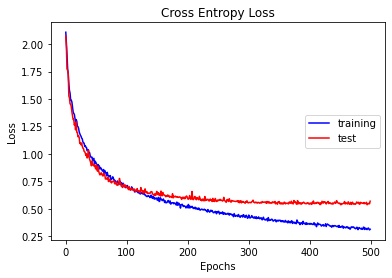

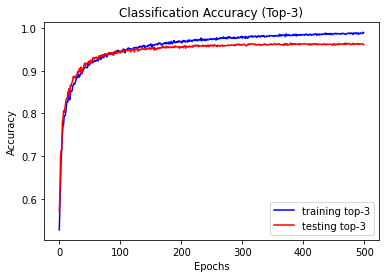

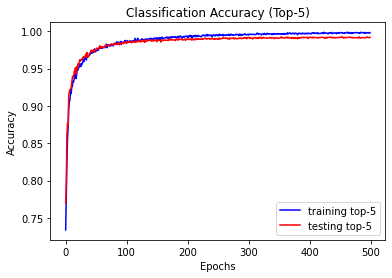

In [ ]:
# Training and test loss against epochs
plt.title('Cross Entropy Loss')
plt.plot(history5.history['loss'], color='blue', label='training')
plt.plot(history5.history['val_loss'], color='red', label='test')
plt.legend(loc="center right")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Training and test accuracy against epochs
plt.title('Classification Accuracy (Top-3)')
plt.plot(history5.history['top3acc'], color='blue', label='training top-3')
plt.plot(history5.history['val_top3acc'], color='red', label='testing top-3')
plt.legend(loc="lower right")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

plt.title('Classification Accuracy (Top-5)')
plt.plot(history5.history['top5acc'], color='blue', label='training top-5')
plt.plot(history5.history['val_top5acc'], color='red', label='testing top-5')
plt.legend(loc="lower right")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
score5 = model5.evaluate(data_test, label_test, verbose=0)
print("Accuracy: %.2f%%" % (score5[1]*100))

Accuracy: 81.67%


The model improved tremendously, reaching the highest accuracy recorded, 81.67%. The test loss reaches a stable rate by epoch 200 and there is no sign of overfitting. The top-3 and top-5 test accuracy values reach all-time high values of 0.97 and 0.99 respectively. Looking at when the loss and accuracy values reach a plateau, it is probably sufficient to train the model over 300 epochs rather than 500.

This model proves that there is value in increasing filters to improve feature learning, while ensuring that overfitting is combated by adding dropout regularisation. Data augmentation from the first improved model will likely aid in overfitting issues as well as expand the dataset to improve training accuracy in general.

#P2

##Set Up

In [ ]:
# Read document
import re
def read_alice_in_wonderland():  
    with open('Lewis-Carroll-book.txt', 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_alice_in_wonderland()

##P2.1

In [ ]:
# Tokenizing
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(lines)
totalchar = sum(tokenizer.word_counts.values())
distchar = len(tokenizer.word_index)+1
print('Data size (number of characters): ', totalchar)
print('Vocabulary size (number of distinct characters): ', distchar)

Data size (number of characters):  151369
Vocabulary size (number of distinct characters):  28


In [ ]:
# Sequencing 
input_sequences = []
for line in lines:
    token_list = tokenizer.texts_to_sequences([line])[0] # converting into sequence of tokens
    for i in range(1, len(token_list)): 
      if i <= int(len(token_list))-49: # ensure that subsequences end at the last token of each line
        partial_sequence = token_list[i-1:i+49] # creating subsequences of 50 tokens
        input_sequences.append(partial_sequence) 

# Creating predictors and targets
input_sequences1 = np.array(input_sequences)
predictors = input_sequences1[:,:-1] # first 49 tokens
labels = input_sequences1[:,-1] # last token

from tensorflow.keras import utils
labels = utils.to_categorical(labels, num_classes=distchar)

##P2.2

In [ ]:
# RNN model
model6 = Sequential(name='model_6')
model6.add(Embedding(distchar, 256, input_length=49)) # 256 dimensions with input units = 49 (length of predictors)
model6.add(LSTM(1024)) # 1024 dimensions
model6.add(Dense(distchar, activation='softmax')) # output units = number of distinct characters
model6.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 49, 256)           7168      
                                                                 
 lstm (LSTM)                 (None, 1024)              5246976   
                                                                 
 dense (Dense)               (None, 28)                28700     
                                                                 
Total params: 5,282,844
Trainable params: 5,282,844
Non-trainable params: 0
_________________________________________________________________


##P2.3

In [ ]:
# RNN model
model6 = Sequential(name='model_6')
model6.add(Embedding(distchar, 256, input_length=49, batch_input_shape=(64, predictors.shape[1]), name='embedding'))
model6.add(LSTM(1024, kernel_initializer='glorot_uniform', stateful=True, name='LSTM'))
model6.add(Dense(distchar, activation='softmax', name='final_output'))
model6.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, 49, 256)             7168      
                                                                 
 LSTM (LSTM)                 (64, 1024)                5246976   
                                                                 
 final_output (Dense)        (64, 28)                  28700     
                                                                 
Total params: 5,282,844
Trainable params: 5,282,844
Non-trainable params: 0
_________________________________________________________________


The model is first built with an embedding layer of dimensions 256. Inputs are fed into the model in batches of size 64, each of length 49, given that we have sliced the document into subsequences of 50 tokens, 49 of them become predictors and the last token becomes the label (what the model will try to predict). It is then fed into an LSTM layer with 1024 hidden units and with the Glorot uniform initialiser, where inputs are drawn randomly from a uniform distribution. Stateful is set to true, where states in each batch will be retained and used in the training of the following batch. This allows dependency and lets the model learn the relationship between the the first character on the final output, for example. These states are reset before the next epoch begins to allow for fresh learning as well. This was done manually with a simple for loop (where the model trains for 1 epoch but is iterated 50 times to imitate 50 epochs) and a custom callback function in subsequent codes.

In [ ]:
# Ensuring batches are all of size 64 since sample is not divisible by 64
train_data = tf.data.Dataset.from_tensor_slices((predictors, labels))
train_data = train_data.shuffle(buffer_size=1000, reshuffle_each_iteration=True) # shuffling dataset to ensure all data points are used
train_data = train_data.repeat().batch(64, drop_remainder=True) # creating batches of size 64 and ignoring those less than 64

# Compile model
model6.compile(loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.01))

# Fit model
loss=[]
for i in range(50):
  history6 = model6.fit(train_data, epochs=1, batch_size=64, steps_per_epoch=(len(predictors)//64), shuffle=True, verbose=0)
  l = history6.history['loss']
  loss.append(l)
  model6.reset_states() # resets states at the start of each epoch

As we are training with a batch size of 64 and stateful is set to True, we need to ensure that all the batches are exactly of the length 64. Our sample is unfortunately not divisible by 64 and we end up with some batches smaller than 64. Thus, we first shuffle the predictors and labels data to ensure that all the datapoints will have an equal chance of being used, then we split them into batches of 64 and drop the remaining datapoints that do not make up a full batch of 64.

After compiling the model, we fit it and obtain the mean loss of each epoch. As there is a need to reset states before every epoch, we fit the model through 50 iterations to force the reset of states.

No handles with labels found to put in legend.


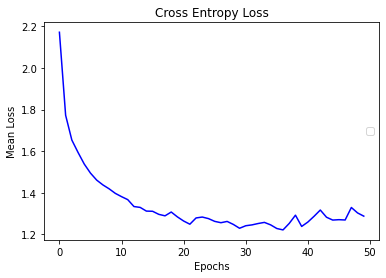

In [ ]:
plt.title('Cross Entropy Loss')
plt.plot(loss, color='blue')
plt.legend(loc="center right")
plt.xlabel('Epochs')
plt.ylabel('Mean Loss')
plt.show()

As the model trains over more epochs, the cross entropy loss decreases. It starts to plateau and stabilise at around epoch 20, where mean loss reaches around 1.25. The actual loss could be obtained by setting verbose=1, however due to computational time issues and the long output it would generate, verbose is set to 0 to maintain efficiency and readability.

The longer the model gets to learn from the dataset, the better it gets at predicting the next character. Towards the end of the 50 epochs, however, loss starts to increase. This could be due to the learning rate being too high, thus the model is failing to locate the local minimum, jumping over it or diverging from it instead. This problem could be avoided by using a lower learning rate or using learning rate scheduler or gradient clipping.

##P2.4

For model prediction, we need to build a slightly modified model. Firstly, the training model was built for input sequences of length 49 for a batch size of 64. There is thus a need to pad the input token 'l' (and subsequent tokens with the added predicted characters) to ensure that input shape remains the same and batch size is changed to 1. This is defined as the prediction model in order to predict and output the next token. A temperature scaling is also added as a Lambda layer. This dense layer scales the inputs by factor 1/T.

Further function are defined to predict the next token. The predict_next_token function transforms the input token (which are in characters form) to its sequence number in order to be put through the model. After padding the input tokens, they are put through the prediction model with the softmax function. The softmax functions gives each character a probability and the character that has the highest probability is selected as the next predicted token. The next function, generate_text, loops the prediction code 999 times in order to produce texts with length of 1000 tokens. After producing an output of 999 tokens in the form of sequence numbers, they are converted to the corresponding characters and added to the previous token(s).

The general steps for prediction is the following:

1) Create training model with batch size of 64 and T parameter to be defined.

2) Compile the model with cross entropy loss and the Adam optimiser set at learning rate of 0.01.

3) Fit the model with the parameters defined before, with the states reset at the start of every epoch. For every 5 epochs, the weights from the best model are saved to output the next predicted token. This is repeated 10 times to imitate 50 epochs in total.

4) Built prediction model with batch size of 1 and the same T parameter.

5) Load the prediction model with the saved weights.

6) Predict the next token with the predefined functions.

In [ ]:
# Model prediction
from keras.layers import Lambda
def create_model(batch_size, T):
  model=Sequential(name='model_pred')
  model.add(Embedding(distchar, 256, batch_input_shape=(batch_size, 49), name='embedding'))
  model.add(LSTM(1024, kernel_initializer='glorot_uniform', stateful=True, name='LSTM'))
  model.add(Lambda(lambda x: x / T, name='softmax_scaling'))
  model.add(Dense(distchar, activation='softmax', name='final_output'))
  return model

from tensorflow.keras.preprocessing.sequence import pad_sequences
def predict_next_token(seed_char):
    token_list = tokenizer.texts_to_sequences([seed_char])[0]
    token_list = pad_sequences([token_list], maxlen=49, padding='pre')
    prediction = np.argmax(model_pred.predict(token_list), axis=-1)
    return prediction
  
def generate_text(seed_char, next_char):
    for _ in range(next_char):
        prediction = predict_next_token(seed_char) # Predict next token
        next_char = tokenizer.sequences_to_texts([prediction])[0] # Convert token to char
        seed_char += next_char # Add char to previous char
    return seed_char.title()

We now investigate how the temperature scaling factor T affects prediction. Different T values scale the inputs accordingly - lower T values scale the inputs larger than higher T values do. When these inputs are fed through the layer with the softmax function, the exponential function would mean that larger logits are penalised and shrink more than smaller logits. More probability mass will then be given to smaller logits than larger logits. This means that a lower T parameter producing large input values would be more sensitive to the penalising, which will give more extreme and certain probabilities closer to either 0 or 1. The model is thus more confident of the prediction. For a smaller T parameter, there is less penalising, thus probability mass is distributed more evenly and the probabilities are less extreme. The model is less confident of the predictions.

In [ ]:
# Compile model for T=0.2
T=0.2
model = create_model(64,T)
model.compile(loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.01))

# Fit model
from keras.callbacks import ModelCheckpoint, LambdaCallback
class ResetStates(keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
      self.model.reset_states()

texts=[]
for i in range(10):
  checkpointer = ModelCheckpoint(filepath='best_models/p%s/n%s' %(T,i), monitor='loss', save_best_only=True, verbose=0)
  history = model.fit(train_data, epochs=5, batch_size=64, steps_per_epoch=(len(predictors)//64),
                        shuffle=True, verbose=0, callbacks=[ResetStates(), checkpointer])
  
  model_pred = create_model(1,T)
  model_pred.load_weights('best_models/p%s/n%s' %(T,i))
  pred_text = generate_text('l', 999)
  texts.append(pred_text)

print('For T=%s:' %T)
print(*texts, sep='\n')

For T=0.2:
Ltothotoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooo

In [ ]:
# Compile model for T=0.5
T=0.5
model = create_model(64,T)
model.compile(loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.01))

# Fit model
texts=[]
for i in range(10):
  checkpointer = ModelCheckpoint(filepath='best_models/p%s/n%s' %(T,i), monitor='loss', save_best_only=True, verbose=0)
  history = model.fit(train_data, epochs=5, batch_size=64, steps_per_epoch=(len(predictors)//64),
                        shuffle=True, verbose=0, callbacks=[ResetStates(), checkpointer])
  
  model_pred = create_model(1,T)
  model_pred.load_weights('best_models/p%s/n%s' %(T,i))
  pred_text = generate_text('l', 999)
  texts.append(pred_text)

print('For T=%s:' %T)
print(*texts, sep='\n')

For T=0.5:
Ly Of The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come Be And The Project Gutenberg Tm Works Come B

In [ ]:
# Compile model for T=1
T=1
model = create_model(64,T)
model.compile(loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.01))

# Fit model
texts=[]
for i in range(10):
  checkpointer = ModelCheckpoint(filepath='best_models/p%s/n%s' %(T,i), monitor='loss', save_best_only=True, verbose=0)
  history = model.fit(train_data, epochs=5, batch_size=64, steps_per_epoch=(len(predictors)//64),
                        shuffle=True, verbose=0, callbacks=[ResetStates(), checkpointer])
  
  model_pred = create_model(1,T)
  model_pred.load_weights('best_models/p%s/n%s' %(T,i))
  pred_text = generate_text('l', 999)
  texts.append(pred_text)

print('For T=%s:' %T)
print(*texts, sep='\n')

For T=1:
Liojererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererererere

In [ ]:
# Compile model for T=1.5
T=1.5
model = create_model(64,T)
model.compile(loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.01))

# Fit model
texts=[]
for i in range(10):
  checkpointer = ModelCheckpoint(filepath='best_models/p%s/n%s' %(T,i), monitor='loss', save_best_only=True, verbose=0)
  history = model.fit(train_data, epochs=5, batch_size=64, steps_per_epoch=(len(predictors)//64),
                        shuffle=True, verbose=0, callbacks=[ResetStates(), checkpointer])
  
  model_pred = create_model(1,T)
  model_pred.load_weights('best_models/p%s/n%s' %(T,i))
  pred_text = generate_text('l', 999)
  texts.append(pred_text)

print('For T=%s:' %T)
print(*texts, sep='\n')

For T=1.5:
Ly And The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Project The Projec

In [ ]:
# Compile model for T=3
T=3
model = create_model(64,T)
model.compile(loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(learning_rate=0.01))

# Fit model
texts=[]
for i in range(10):
  checkpointer = ModelCheckpoint(filepath='best_models/p%s/n%s' %(T,i), monitor='loss', save_best_only=True, verbose=0)
  history = model.fit(train_data, epochs=5, batch_size=64, steps_per_epoch=(len(predictors)//64),
                        shuffle=True, verbose=0, callbacks=[ResetStates(), checkpointer])
  
  model_pred = create_model(1,T)
  model_pred.load_weights('best_models/p%s/n%s' %(T,i))
  pred_text = generate_text('l', 999)
  texts.append(pred_text)

print('For T=%s:' %T)
print(*texts, sep='\n')

For T=3:
Ly Or Seeme The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The Project To The 

The model is run on five T values, T=0.2, T=0.5, T=1, T=1.5 and T=3.

With T=0.2, the character prediction patterns repeat and there is little variation in next character prediction. The words formed make little sense and there are absurd predictions such as "Werk Werk Werk Werk Werk Werk", which sounds like Rihanna's hit song and clearly does not exist in the Alice in Wonderland text. Predictions seem to improve after training over more epochs. Nonetheless, the same words always form - "Sion", "Project", "Parg", and "Onoted". The token "i" almost always predicts "t" as its next token and "a" usually predicts "r". This is a sign of an overconfident model. As inputs are scaled to a large magnitude and put through an exponential function, probabilites calculated will be extreme, leading to very confident predictions. Thus, the same token will usually predict the same subsequent tokens (although still dependent on what has already been predicted as states are retained within each epoch) and this gives little variation in prediction.

With a higher value T=0.5, the model is less confident than before but still exhibits signs of an overconfident model as the same starting token 'l' always predicts "y" as the next token. Similar to T=0.2, predictions get better with epochs, forming more complex words as the model is able to train over more vocabulary for a longer time.

With T=1, the model takes on the default softmax function and original probabilities. Predictions are still very repetitive and the words formed by predicted tokens are likely words that appear frequently in the text, such that their probabilities are high. These are stop words like "for", "it", "the" and "of". "Project Gutenberg" appear often as well, as it is the platform that digitalised the Alice in Wonderland text and thus has its watermark all over the text.

With higher T values of T=1.5, inputs are being recalibrated to produce a more uniform probability distribution. This allows for more varied predictions. The starting token "l" outputs texts that are more than just "Project Guternberg" and stop words, but start to predict tokens that form words like "provide" and even phrases like "and when she works" and "works in a secured".

We see the same pattern for T=3. The same starting token(s) start to predict different tokens each time rather than generating and repeating the same word over and over again. As probabilities are more even distributed, the model no longer sticks to the same confident prediction that has an extremely high probability, but is able to pick out from more varied tokens, which will subsequently provide more variation down the sequence. For example, with the same starting tokens "Ly ", the model predicts six different tokens out of the eight times it has been fed into the model. An overconfident model would have predicted the same one or two tokens every time.

In general, a higher T value should work better for text prediction models as the purpose is to achieve a more diverse text rather than generate the same tokens over and over again. Having a higher T value will allow the model to go beyond tokens that have high probabilities (due to its frequent appearance as a stop word or character's name etc.) and predict different tokens each time.

###Alternative Code

In [ ]:
# Code using for loop but with extremely long computational time

for T in (0.05, 0.5, 0.8):
  model = create_model(64,T)

  # Compile model
  model.compile(loss='categorical_crossentropy',
      optimizer=tf.optimizers.Adam(learning_rate=0.01))

  # Fit model
  print('for T=%s' %T)
  for i in range(10):
    checkpointer = ModelCheckpoint(filepath='best_models/p2.4.%s.%s' %(T,i), monitor='loss', save_best_only=True, verbose=0)
    history = model.fit(train_data, epochs=5, batch_size=64, steps_per_epoch=(len(predictors)//64),
                          shuffle=True, verbose=0, callbacks=[ResetStates(), checkpointer])
    
    model_pred = create_model(1,T)
    model_pred.load_weights('best_models/p2.4.%s.%s' %(T,i))
    pred_text = generate_text('l', 999)
    print('predicted text %s: %s' %(i+1, pred_text))